# About this notebook

In this notebook we consider a network generate by an suceptible-infected-recovered (SIR) model.
The notebook is intended to compare the common contact tracing strategy with the inference methods developed in our group on an idealised model running on a random geometric graph.


### Description of the sections

- Import function and dataset from the <a href="https://github.com/sphinxteam/sir_inference/">github repository</a>;
- Generate the SIR evolution;
- Given partial observations on the population, identify the individuals that are most likely to be infected using different strategies;

Furthermore, this notebook contains the same study for two set of parameters of the epidemic spread, the first section is with a set of parameters for which the inference problem works well. In the appendix we present a set of parameters for which the inference works less well.

### Goal

The notebook aim to show the efficacy of the propesed inference network.

# Imports

In [1]:
!git init .
!git remote add origin https://github.com/sphinxteam/sir_inference
!git pull origin master

Initialized empty Git repository in C:/Users/Frank/Documents/GitHub/Demo2/.git/


From https://github.com/sphinxteam/sir_inference
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as mm

# sir_inference imports
from sir_model import ProximityModel, patient_zeros_states
from observations_scenario import run_observations, ranking_observations
from scenario import get_detected_by

# SIR Model (Proximity)

We consider a Susciptible-Infected-Removed (SIR) model to simulate the spreading of the epidemics.

- An infected individual $j$ may be removed with constant probabilty $\mu$.

- Once in the removed states the individual can not change state anymore.

In more details, the model is runs on a geometric graph i.e. amoung the population of $N$ individuals a contact between individuals $i$ and $j$ occurs, at time $t$ with a probability $p^{ij}_{\text{contact}}(t)=\operatorname{e}^{\frac{-\text{dist}(i,j)(t)}{\text{scale}}}$, where scale is a constant of the model. The parameters of the epidemics are $\lambda$, i.e. the transmission rate given there was contact between two individuals and $\mu$, the recover probability. Here, they are constant both in time and amoung individuals.
- A susceptible individual $i$ may become infected with a probability tha depends on the number of contacts he had with infected people, $n_i$. The probability to become infected is $1 - (1-\lambda)^{n_i}$ where $\lambda$ is a parameter of the model.

The cell below we consider a populations of $4000$ individuals that evolves starting from $10$ infected people with a SIR dynamics of parameters $\lambda = 0.02$ and $\mu = 0.01$.
The number of susceptible, infected and removed individuals in shown in the plot.

expected number of contacts 6.0
Generating transmissions
t = 0 / 100
Running SIR simulation
t = 0 / 100


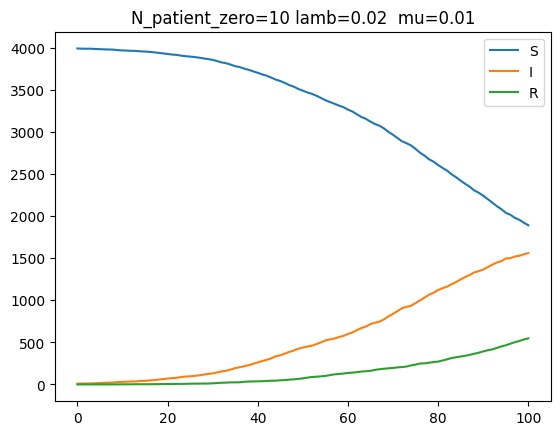

In [2]:
N=4000
N_patient_zero = 10;
lamb = 0.02;
mu = 0.01;
scale=1.0; # Easy Case
T=100
seed=10
np.random.seed(seed);

initial_states = patient_zeros_states(N, N_patient_zero)
model = ProximityModel(N, scale, mu, lamb, initial_states)
print("expected number of contacts %.1f" % model.n_contacts)
model.run(T=T, print_every=100)
model.get_counts().plot(
    title=f"N_patient_zero={N_patient_zero} lamb={lamb:.2f}  mu={mu:.2f}"
);

# Infer the infected people


We consider observations coming from two kind of sources: 50% from *infected people* that were recognized, 50% from *random tests* on the populations. The number of tests per day is assumed to be limited to `tests_per_day`. At time `t_final` we used the observations collected so far to identify the possible infected people in the population.

**Strategies**

- *Dynamical Message Passing* : an approximated Bayesian approach to the problem that is exact in tree-like graphs. The method has a parameter `delta` that fixes the time where the inference is initialized to an all-susceptible prior. This gives more importance on the last observations.


- *Mean-Field inference* : a simplification of the method described above. The parameter `delta` applies here likewise.


- *Contact tracing* : given the observation of an infected invidual, look for people that have been in contact with an infected subject in a period of time `delta` from the observation. Note that in most applications `delta` is chosen as $\tau$ the mean recovery time of individuals in a population.


- *Random strategy (baseline)* : sample at random individual to test in a population.



### Comparing the tracing Strategies

The cell below show a representing the number of infected people correctly identified at `t_final` given the `n_daily_tests` observations collected each day befor `t_final`.

We consider a recovery rate $\tau$ fixed at $\tau=7$ and `delta`=21 and `n_daily_tests`=20.

#### Helper function

Compare ranking strategies at t_final, given a number of daily tests.   
Generate n daily tests random tests+ n daily tests tests amoung infected individuals infected observations from t_start to t_final.
Then at t_final compare the rankings proposed by different strategies.

In [ ]:
def plot_daily_test(model, n_daily_test, t_final,delta,tau,t_start, ax=None, xlim=None, ylim=None, verbose=False, ROC=False):
    """Compare ranking strategies at t_final, given a number of daily tests

    Generate n_daily_test random + n_daily_test infected observations from t_start to t_final.
    Then at t_final compare the rankings proposed by different strategies (set in all_params).
    """
    # Generates the observations from t_start to t_final
    past_params = dict(
        t_start = t_start,
        t_final = t_final,
        n_test = dict(random=n_daily_test, infected=n_daily_test, ranking=0)
    )
    past_observations = run_observations([], model, past_params)
    # count infected and remaining
    infected, = np.where(model.states[t_final,:]==1)
    already_tested = [obs["i"] for obs in past_observations if obs["s"]==1]
    remaining = [i for i in infected if i not in already_tested]
    n_infected = len(infected)
    n_remaining = len(remaining)
    if verbose:
        print(f"{n_remaining} remaining people to detect, among {n_infected} infected people")
    # dict of label : params of ranking
    #The strategies that are to be used
    all_params = {
        "random": dict(ranking="random"),
        "tracing": dict(ranking="tracing", tau=tau),
        f"MF (all_S delta={delta})": dict(ranking="backtrack", algo="MF", init="all_S", tau=tau, delta=delta),
        f"MF (all_S t_start={t_start})": dict(ranking="inference", algo="MF", init="all_S", tau=tau, t_start=t_start),
        f"DMP (all_S delta={delta})": dict(ranking="backtrack", algo="DMP", init="all_S", tau=tau, delta=delta),
        f"DMP (all_S t_start={t_start})": dict(ranking="inference", algo="DMP", init="all_S", tau=tau, t_start=t_start)
    }
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(4,4))
    for label, params in all_params.items():
        # rank at t_final with given params
        if verbose:
            print(f"Ranking at t_final={t_final} using {params}")
        df = ranking_observations(t_final, model, past_observations, params)

        if ROC:
            y_true = df["infected"]
            y_score = df["score"]
            fpr, tpr, thresholds=mm.roc_curve(y_true, y_score)
            ax.plot(fpr, tpr, label=label)
        else:
            ax.plot(df["tested"], df["detected"], label=label)
    if ROC:
        ax.legend()
        ax.set(
            xlabel="False positive rate", ylabel="True positive rate",
            title=f"{n_daily_test} daily tests t_final={t_final}",
            xlim=(-0.01,1.01),
            ylim=(-0.01,1.01)
        )
    else:
        ax.plot([0, n_remaining, model.N], [0, n_remaining, n_remaining], label="perfect")
        ax.legend()
        ax.set(
            xlabel="number of tests", ylabel="detected",
            title=f"{n_daily_test} daily tests t_final={t_final}"
        )
        if xlim: ax.set(xlim=xlim)
        if ylim: ax.set(ylim=ylim)

def plot_multiple_daily_tests(model, n_daily_tests, t_finals,delta,tau,t_start, xlim=None, ylim=None, ROC=False):
    "Plot ranking performance for several n_daily_test and t_final"
    fig, axs = plt.subplots(
        len(t_finals), len(n_daily_tests),
        figsize=(5*len(n_daily_tests),4*len(t_finals)),
        sharey=True, sharex=True
    )
    for t_final, row in zip(t_finals, axs):
        for n_daily_test, ax in zip(n_daily_tests, row):
            plot_daily_test(
                model, n_daily_test, t_final,t_start=t_start,delta=delta,tau=tau, ax=ax,
                xlim=xlim, ylim=ylim, ROC=ROC
            )
    fig.tight_layout()

## Run and plots


In [ ]:
t_final = 40
n_daily_test = 8
tau=7
delta=7
t_start=20

Plot either the number of infected as a function of the number of tests (`ROC_plot=False`) or the ROC curver (`ROC_plot=True`).

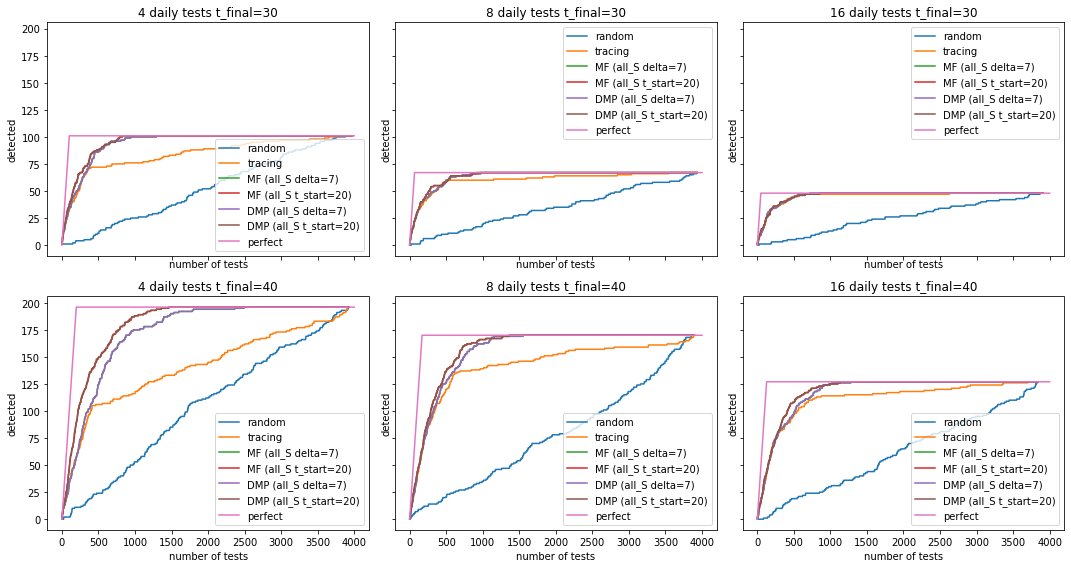

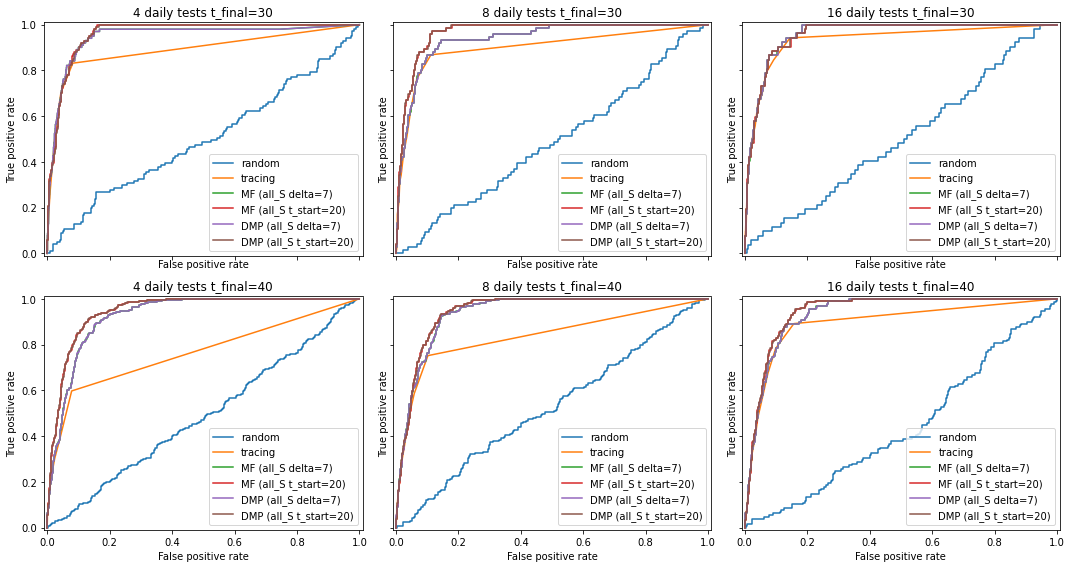

In [ ]:
plot_multiple_daily_tests(
    model, n_daily_tests = [4, 8, 16], t_finals = [30, 40],
    t_start=t_start,delta=delta,tau=tau,ROC=False
)

plot_multiple_daily_tests(
    model, n_daily_tests = [4, 8, 16], t_finals = [30, 40],
    t_start=t_start,delta=delta,tau=tau,ROC=True
)

#### Helper function - Using the ranking strategies

Compares the different ranking strategies through time, given a number of daily tests.
    
Generate n daily tests random +  n daily tests infected +  n daily tests ranking observations so the total number of tests per day is 3*n daily tests
from t_start to t_final. We compare the total number of people detected thanks to the rankings
proposed by different strategies (set in all_params).

Here we choose the same parameters as in the precedent case.

In [ ]:
def plot_total_detected(model, t_start, t_final, n_daily_test,delta, tau, ax=None, xlim=None, ylim=None, verbose=False):
    """Compare ranking strategies through time, given a number of daily tests.

    Generate n_daily_test random + n_daily_test infected + n_daily_test ranking observations
    from t_start to t_final. We compare the total number of people detected thanks to the rankings
    proposed by different strategies (set in all_params).
    """
    # shared params
    shared_params = dict(
        t_start = t_start,
        t_final = t_final,
        n_test = dict(random=n_daily_test, infected=n_daily_test, ranking=n_daily_test)
    )
    # dict of label : params of ranking
    # uncomment if you want DMP
    all_params = {
        "random": dict(ranking="random"),
        "tracing": dict(ranking="tracing", tau=tau),
        f"MF (all_S delta={delta})": dict(
            ranking="backtrack", algo="MF", init="all_S", tau=tau, delta=delta
        ),
        f"MF (all_S t_start={t_start})": dict(ranking="inference", algo="MF", init="all_S", tau=tau, t_start=t_start),
        #f"DMP (all_S delta={delta})": dict(ranking="backtrack", algo="DMP", init="all_S", tau=tau, delta=delta),
        #f"DMP (all_S t_start={t_start})": dict(ranking="inference", algo="DMP", init="all_S", tau=tau, t_start=t_start)
    }
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(4,4))
    for label, rank_params in all_params.items():
        params = shared_params.copy()
        params.update(rank_params)
        if verbose:
            print(f"Ranking at all times using using {rank_params}")
        observations = run_observations([], model, params)
        df = get_detected_by(observations, "ranking").reset_index()
        ax.plot(df["t_test"], df["total_detected"], label=label)
    ax.legend()
    ax.set(
        xlabel="t", ylabel="total detected",
        title=f"{n_daily_test} daily tests"
    )

def plot_multiple_total_detected(model,t_start, n_daily_tests, t_finals,delta,tau, xlim=None, ylim=None):
    "Plot ranking performance for several n_daily_test and t_final"
    fig, axs = plt.subplots(
        len(t_finals), len(n_daily_tests),
        figsize=(5*len(n_daily_tests),4*len(t_finals)),
        sharey=True, sharex=True
    )
    for t_final, row in zip(t_finals, axs):
        for n_daily_test, ax in zip(n_daily_tests, row):
            plot_total_detected(
                model=model, n_daily_test=n_daily_test, t_final=t_final,t_start=t_start,delta=delta,tau=tau, ax=ax,
                xlim=xlim, ylim=ylim
            )
    fig.tight_layout()

## Run and Plot

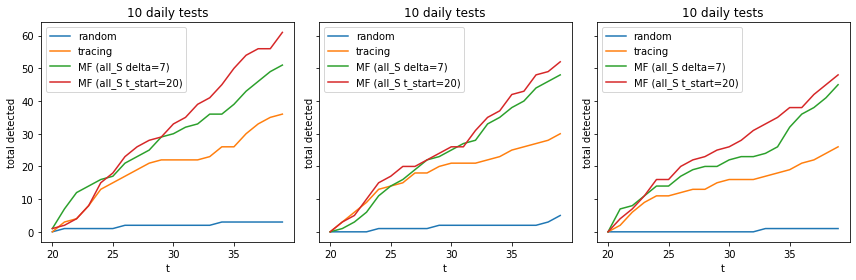

In [ ]:
# you can uncomment the DMP entries in plot_total_detected -> all_params
# if you want to plot them, but it will take a while
fig, axs = plt.subplots(1,3,figsize=(12,4),sharex=True, sharey=True)
for ax in axs.ravel():
  plot_total_detected(
      model, t_start=20, t_final=40, n_daily_test=10,
      tau=tau, delta=delta, ax=ax
  )
fig.tight_layout()